# Elements of an `AgentType` Subclass

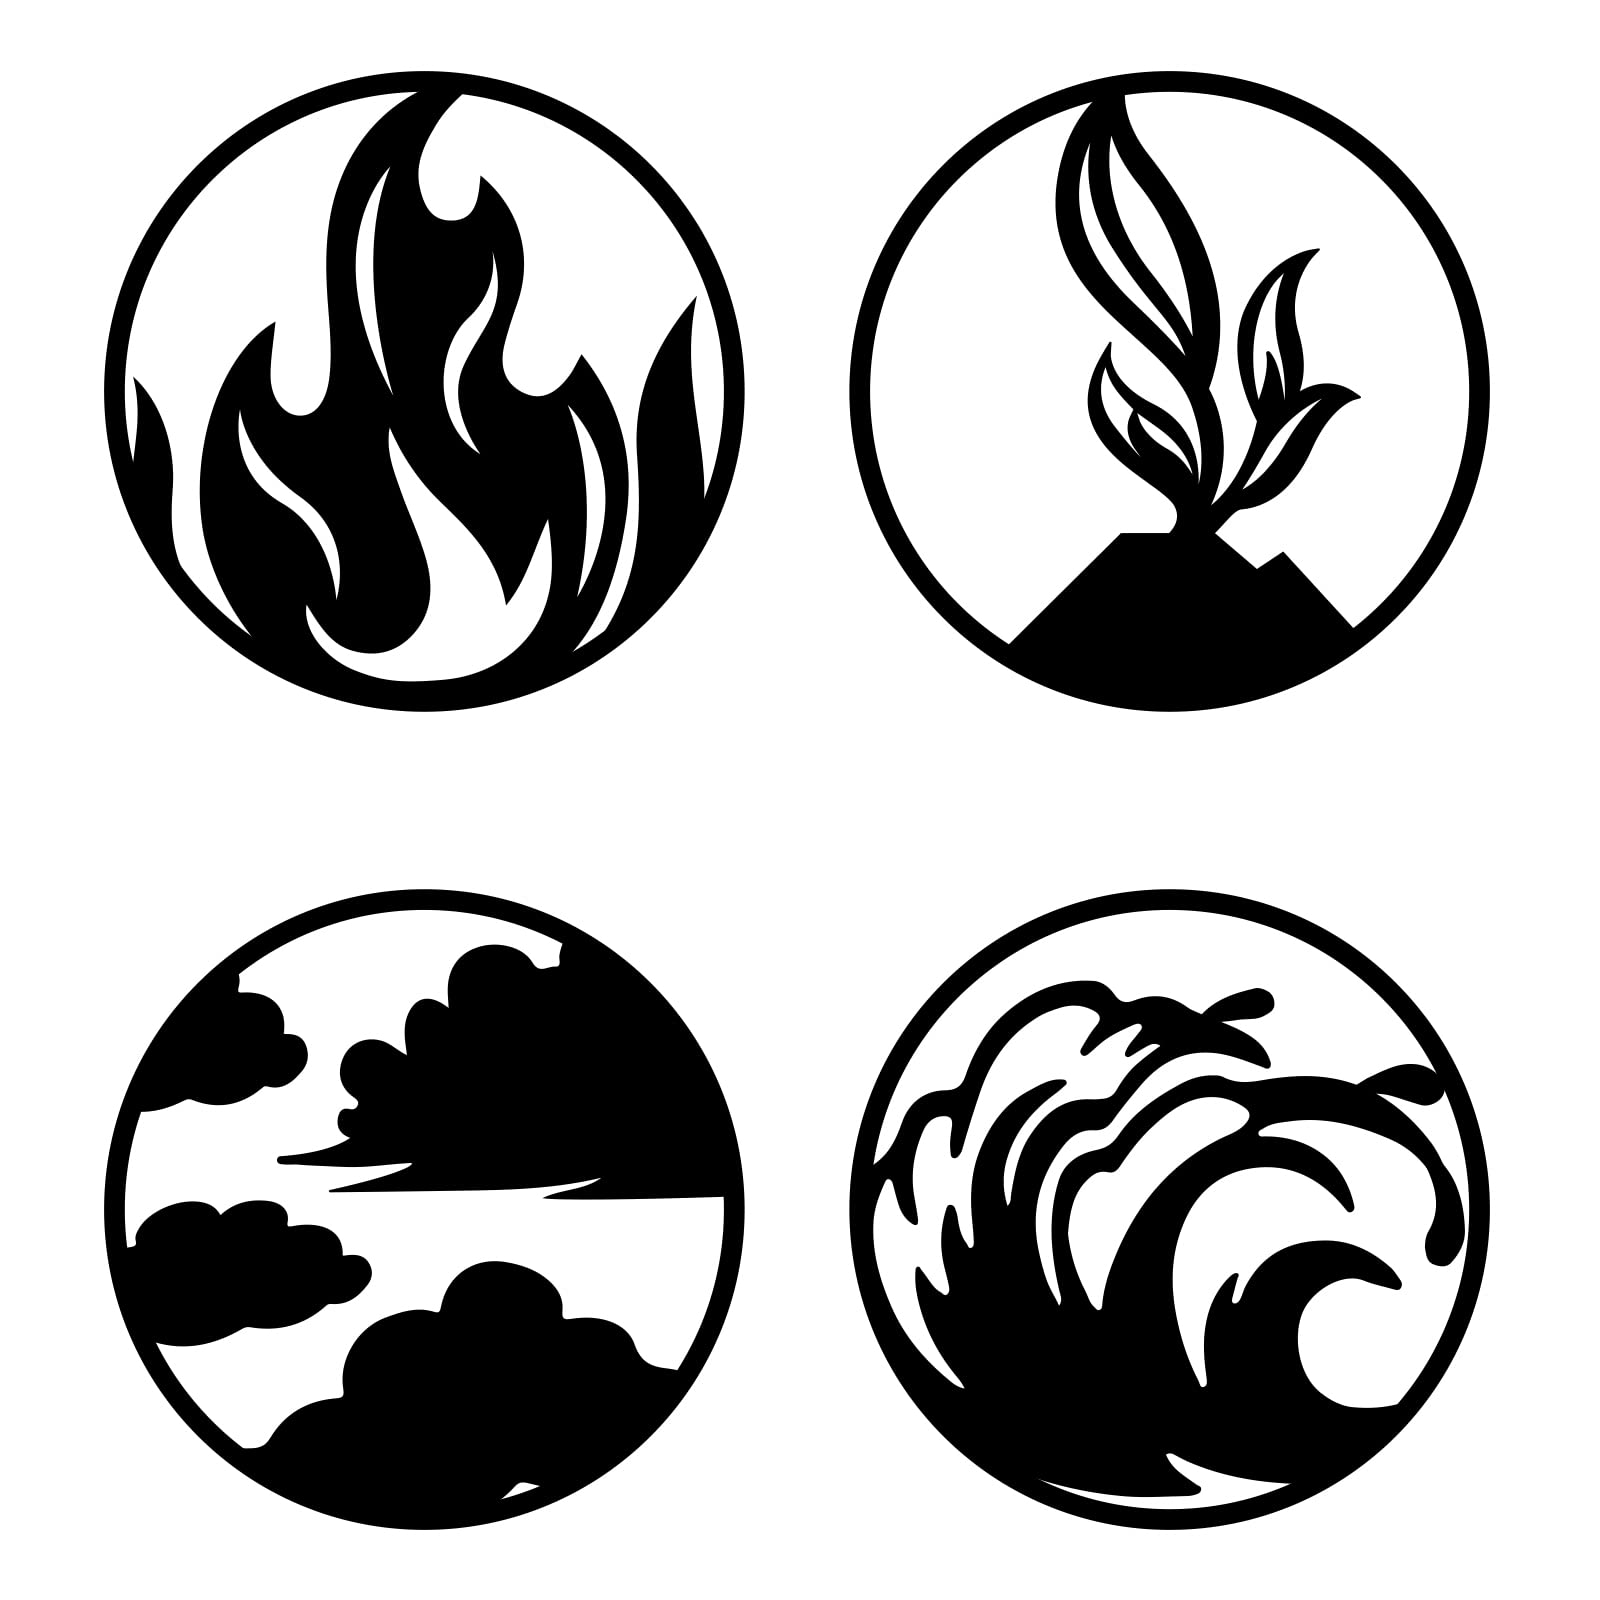

In [1]:
from IPython import display

display.Image("../../docs/images/elements_thumbnail.jpg", width=200)

Other introductory notebooks have used `AgentType` subclasses like `PerfForesightConsumerType` and `IndShockConsumerType` to show HARK's representation of microeconomic agents. The basic functionality for `AgentTypes` is also covered in other notebooks, including setting parameters, solving the model, and generating simulated outcomes. But those notebooks don't tell you much about *how* an `AgentType` subclass works or what goes into one; that's what we'll cover those elements here!

## Time-Varying and Time-Invariant Solver Inputs

When it's time to solve a model, HARK reads in the required inputs from the attributes of the `AgentType` instance and/or its `parameters` dictionary. But some parameters are **time-invariant**-- constant across all periods of the model-- while others might vary across periods and are **time-varying**. The latter kind of solver inputs should consist of a list of length `T_cycle`, with one element per period, while the former are just single objects.

HARK differentiates between the two by looking at the attributes `time_vary` and `time_inv`, which are lists of strings naming the time-varying and time-invariant solver inputs. These are *instance*-specific lists-- making changes to `time_vary` on one instance of an `AgentType` subclass won't affect the properties of another instance of that class.

At the class level, `time_vary` and `time_inv` default to the class attributes `time_vary_` and `time_inv_` at instantiation (note the extra underscore at the end). Each `AgentType` subclass should specify these lists, naming the appropriate solver inputs in each category *for the default parameters*.

Almost all model inputs can be freely moved between `time_vary` and `time_inv`, as long as the parameter values are changed appropriately as well. In some cases, there might not be a meaningful interpretation to a model object being time (in)variant (e.g., something that is supposed to represent a universal constant somehow varying with a particular agent's age), but that doesn't prevent HARK from solving the model.

The primary exception (which we hope to fix in the future) is `CRRA`, the coefficient of relative risk aversion with respect to consumption. HARK's solvers *assume* that risk aversion is constant across all periods and incorporate this into their math.

Moreover, the *original/legacy* simulation system will not behave properly if model objects are moved between `time_vary` and `time_inv`. However, the new simulation machinery (using `symulate`, etc) *does* automatically handle changes to `time_vary` and `time_inv`. In some cases, you might need to add a `+` to an object's declaration in the model file if it is time-invariant by default but "offset" in time if interpreted as time-varying.

## Taking it One Day at a Time: `solve_one_period`

Each `AgentType` subclass needs a function that solves the "one period problem" for that model. This function takes as arguments a representation of next period's model solution and all of the information needed to solve the period $t$ problem, and returns a single object representing the solution to the period $t$ problem.

This function is stored on each `AgentType` instance in the `solve_one_period` attribute. When an instance of an `AgentType` subclass is created, `solve_one_period` is set based on the value in `default_["solver"]`, a class attribute with model defaults (see [here](./Constructors-Intro.ipynb) for more about model defaults). The `solve_one_period` function can be changed after instantiation on an instance-by-instance basis-- maybe you have a different way of solving the same model!

The argument name for the succeeding period's solution *must* be `solution_next`. By convention, it is the first argument to a `solve_one_period` function, but this is not required. Don't put `solution_next` in `time_vary` (nor `time_inv`); it's a special name that HARK uses internally.

All other argument names should refer to attributes of the `AgentType` instance.

### Representing the Model's Solution

What does it mean for an object to represent the solution to one period of a model? It completely depends on the context!

In general, HARK models have special object classes for representing the model solution. These are usually just "container classes" that hold named attributes of the solution, but they *might* have methods built into them. In principle, the representation of one period's solution could be a single policy function, or a dictionary of solution elements (rather than a simple class).

As an example, many HARK models use the class `ConsumerSolution` from `HARK.ConsumptionSaving.IndShockConsumerType` to represent the solution to one period. This class specifies that it has the following attributes (all of which are optional):

- `cFunc` : The consumption function over the state space at decision-time
- `vFunc` : The value function over the state space at decision-time
- `vPfunc` : The marginal value (w.r.t market resources) function over the state space at decision-time; the `P` is for "prime"
- `vPPfunc` : The marginal marginal value (w.r.t market resources) function over the state space at decision-time
- `mNrmMin` : The smallest "legal" value for normalized market resources at decision-time
- `hNrm` : Normalized "human wealth"-- the PDV of *future* non-capital income
- `MPCmin` : Lower bound of the marginal propensity to consume from market resources as $m_t$ goes to infinity
- `MPCmax` : Upper bound of the marginal propensity to consume from market resources as $m_t$ approaches `mNrmMin`

`ConsumerSolution` has one method, `append_solution`, which is used in `ConsMarkovModel` to add a discrete-state-conditional solution to the existing solution.

### Perhaps You Had Better Start From the End: `solution_terminal`

The meaning of the "succeeding period's solution" is usually pretty clear, but what about when the `solve` method first starts-- how can it pull down the "next" period's solution if it's trying to solve the *final* period?

HARK deals with this complication by having a special attribute called `solution_terminal`. This object should be a representation of the solution to the one-period problem that can be passed as `solution_next` to the `solve_one_period` function. It is referenced by the `solve` method *only* when trying to solve the very first period-- er, the *last* period.

The object in `solution_terminal` can be built with a constructor function. It is also possible to pass `solution_terminal` as an argument when instantiating an `AgentType`, or to manually set it later.

In many models, the solution to the period $T$ problem is trivial. E.g. for an `IndShockConsumerType`, the solution to the terminal period is, "consume all market resources, and get value equal to the utility of doing that." The constructor for `solution_terminal` builds a `ConsumerSolution` instance that represents this trivial solution, and then the main loop of the `solve` method takes it from there.

In other models, even period $T$ isn't trivial to solve, and there's meaningful work to be done. For example, in the presence of a "warm glow" bequest motive, an agent who knows he will die at the end of this period must choose how to allocate his resources between consumption and their bequest. The ordinary `solve_one_period` function can be used to solve the period $T$ problem... but it still needs *something* to be passed to it as `solution_next`. Thus in the `ConsBequestModel`, `solution_terminal` is essentially an "empty" solution for a non-existent period $T+1$ solution. It *exists* in the computer, but is not meaningfully used when solving period $T$ (because there is zero chance of survival).

The distinction between these two interpretations of a "terminal" solution object is indicated by the attribute `pseudo_terminal`:

- `pseudo_terminal=False` means that the object in `solution_terminal` really *is* the period $T$ solution; agents can actually reach this period and act on its policy function
- `pseudo_terminal=True` means that the object in `solution_terminal` is a "fake" solution to a non-existent period; it exists only to allow the solver to start and is not really part of the agent's "solution" to their model.

## Simulation Variable Names

HARK has a built-in system for simulating model outcomes-- two systems, in fact-- and there are some `AgentType` subclass attributes that should be set to enable this.

### Nothing's Shocking: Random Variables and Distributions

When an `AgentType` instance is simulated, random variables are drawn from **distributions** as **shocks**.

The names of shock variables must be named (as a list of strings) in the class attribute `shock_vars_`. For example, the `IndShockConsumerType` specifies that `shock_vars_ = ['PermShk', 'TranShk']`, meaning that permanent and transitory income shocks will occur.

The distributions from which shocks are drawn should be named in the class attribute `distributions` (as a list of strings). For example, a `PerfForesightConsumerType` has `distributions = ['kNrmInitDstn', 'pLvlInitDstn']`, and `IndShockConsumerType` adds `"IncShkDstn"`, `"PermShkDstn"`, and `"TranShkDstn"` to this list. The first two distributions are used when idiosyncratic agents are "born" in the model, specifying the distributions of initial capital and permanent income; the others are for drawing income shocks during the model.

The names in this list are used for two purposes:

1. When an `AgentType` instance's `reset()` method is invoked, the `distributions` attribute tells HARK which distributions should be reset to their initial random state. This allows the same sequence of random values to be drawn on repeated simulation runs, which is important for many applications.
2. The legacy simulation system stores shock variable outcomes separately from other simulated data. For compatibility with the `read_shocks` functionality (in which the history of random draws can be drawn in advance or manually specified), `shock_vars_` needs to name these variables.

### State Variable Names

HARK's legacy simulation system was in transition when development on it stopped, and it separately tracks state variables separately from control variables. As discussed below, the `transition` method for an `AgentType` subclass should return its output in the order of variables named in `state_vars`. The `transition` method does not need to return all `state_vars`, but it must return the ones it does *in order*.

For example, `PerfForesightConsumerType` and `IndShockConsumerType` both have `state_vars` of `["kNrm", "pLvl", "PlvlAgg", "bNrm", "mNrm", "aNrm", "aLvl"]`, and the `transition` method returns `kNrm, pLvl, PlvlAgg, bNrm, mNrm`. The other two variables, `aNrm` and `aLvl`, are computed later in the period.

## Legacy Simulation System Methods

The original/legacy simulation system is being phased out of HARK, but is fully functional. The `simulate()` method calls the `sim_one_period()` method of `AgentType` on a loop, writing tracked variables to the `history` dictionary after each simulated period.

When `sim_one_period` is run, the following sub-methods are called in order:

- `get_mortality` : "Kills" and replaces some model agents with "newborns".
- `get_shocks` or `read_shocks_from_history` : Fills in shock variables for this period.
- `get_states` : Computes information known at "decision-time" from prior state information and shock variables.
- `get_controls` : Evaluates the policy function using decision-time state variables.
- `get_poststates` : Compute variables that come *after* decision-time but still within this period.

### Show Me How the Model Kills: `sim_death` and `sim_birth`

The `get_mortality` method of `AgentType` should not be overwritten by subclasses. Instead, an `AgentType` subclass should define methods called `sim_death` and `sim_birth`.

The `sim_death` method should return a Boolean array indicating which agents die between period $t-1$ and period $t$ and should be replaced with newborns, whatever that involves. If death and replacement is not a thing in your model, just return `np.zeros(self.AgentCount, dtype=bool)`.

The `sim_birth` method should take one argument (other than `self`), a Boolean array of length `AgentCount`. The method should fill in beginning-of-period state values for any and all indices that are marked for death and replacement. These state values should be put in the appropriate entries of the `state_now` dictionary.

Additionally, `sim_birth` should reset `t_age` and `t_cycle` for newborns. The former represents how many periods each simulated agent has "lived for", and the latter indicates which period of the "cycle" they are on. In most cases, this means setting them to zero for newborns.

The output of `sim_death` is stored in the attribute `who_dies`, which can be tracked like any other variable.

### That's So Random: `get_shocks` and `read_shocks`

Each `AgentType` subclass that wants to use the legacy simulation method should have a `get_shocks` method that draws any random variables for this period. The values should be written to entries in the `self.shocks` dictionary.

The legacy system has an option for pre-drawing all shocks. To do so, simply run the `make_shock_history()` method, which will fully populate the `shock_history` dictionary and set a flag called `read_shocks`, which is `False` by default. When `read_shocks=True`, the `read_shocks_from_history` method is called in place of `get_shocks`; as expected, it takes pre-drawn shocks from `shock_history` and passes them along as if they were freshly drawn.

Note that you do not need to run `make_shock_history` to use `read_shocks=True`. You *can* manually fill in the content of `shock_history` with whatever sequences of idiosyncratic values you'd like and manually set `read_shocks` to `True`. This can be useful for counterfactual experiments that move a population out of the long run ergodic distribution with some exogenous event.

**NB:** The new simulation system currently lacks `read_shocks` capability, which is one reason the legacy system still exists.

### Getting to the Point: `transition`

The `get_states()` method simply calls the `transition` method and assigns its output to the `state_now` dictionary; it should not be overwritten by `AgentType` subclasses.

The `transition` method for an `AgentType` subclass should execute any model math that advances the agents from their beginning-of-period state to their decision-time state, probably using the results of the `get_shocks` step. As described above, it should *return* its outputs in the order listed in the `state_vars` class attribute.

### I'm a Man of Action: `get_controls`

The `get_controls()` method for an `AgentType` should evaluate the policy or control functions (and any related functions) for the agents. This step *probably* involves some of the state variables listed in `state_vars`. Controls should be stored as entries of the `controls` dictionary attribute.

### Wrapping Up: `get_poststates`

The `get_poststates()` method of an `AgentType` subclass is for calculating any model outcomes that occur *after* the control decision is made, but before the end of the period. This might involve combining decision-time states and control variables to find end-of-period states.

For example, in most consumption-saving models, end-of-period assets would be computed by `get_poststates` as $a_t = m_t - c_t$.

All results should be stored as entries of the `state_vars` dictionary attribute.

### Why Is This So Complicated?

A reasonable person might ask why we structured the original/legacy simulation system this way. Our intent was to reduce repetitive coding by allowing "child models" that build from "parent models" to inherit the simulation methods through class inheritance. The "child model" would replace *only* the simulation methods that actually differ from its parent.

For example, the `KinkedRconsumerType` inherits from `IndShockConsumerType`, with the only change being that the single interest factor `Rfree` is replaced by separate interest factors for borrowing and saving, `Rboro` and `Rsave`. *All* of the model mechanics during simulation are the same *except* for how $\mathsf{R}$ is determined. The `KinkedRconsumerType` thus only replaces one small sub-routine (called `get_Rfree`) and otherwise defines *no* simulation methods.

More strongly, almost all of HARK's consumption-saving models use the same `sim_birth` method-- or at least call it as part of their extended `sim_birth` method. That is, most of our models *begin* with the agents drawing some initial permanent (or persistent) income level and some starting wealth.

As the set of models in HARK grew, however, the simulation methods became increasingly complicated. We had to build in features to "parent" models that were *not used* by them, just to accommodate things in "child" models. This can lead to confusion by a user who is investigating the code and finds bizarre trivial methods like `PerfForesightConsumerType.get_Rfree()`, which just returns `self.Rfree`.

Moreover, the way we coded these methods locked in the time (in)variant nature of model objects, because whether they are indexed by `t_cycle` in the simulation methods is hard-coded. This reduces user flexibility to change the specification.

### I Don't Want To and You Can't Make Me

What if you want to make a new `AgentType` subclass, but *don't* want to futz about with all of the methods described above? You have two main options:

1. Use HARK's new simulation system by specifying the model in YAML format and using `symulate` rather than `simulate`.
2. Write an all-in-one `sim_one_period` method that handles *all* of the within-period mechanics, whatever that involves.

Both of these approaches are compatible with using `track_vars` to specify the set of idiosyncratic outcomes to be recorded in the `history` (or `hystory`) dictionary, and using `simulate()` to handle the main loop.

## Extra Steps: `pre_solve` and `post_solve`

When the `solve()` method is called, HARK first runs the `pre_solve` method for that `AgentType` subclass. The default behavior of `pre_solve` doesn't do much-- just checks whether each attribute named in time-varying is actually a list (or other iterable, like an `IndexDistribution`).

Subclasses of `AgentType` can overwrite `pre_solve` to conduct whatever activities need to be accomplished *just before* the main solution loop. This most likely includes (re-)constructing `solution_terminal` in case any parameters have changed, or maybe even rebuilding *all* constructed objects by calling `update()`.

Likewise, HARK runs the `post_solve()` method immediately *after* completing the model solution, but before exiting the call to `solve()`. By default, `AgentType.post_solve()` does *nothing*, so it must be overwritten by a subclass to do anything. This is useful for any "post-processing" steps.

In an infinite horizon model, there might be math that you *don't* want to be executed on each iteration, but you *do* want evaluated for the final solution. For example, an `IndShockConsumerType`'s `post_solve` method calls the method `calc_stable_points()` if it is a standard infinite horizon problem (`T_cycle=1`) to find the "target" level of market resources.

Even more basically, `post_solve` might run convenience methods like `unpack()`, remapping attributes of the solution to be attributes of `self` for lazier access.